<a href="https://colab.research.google.com/github/jackylshi/TrendStudyML/blob/main/HMM_Trendline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --user git+https://github.com/hmmlearn/hmmlearn

  Cloning https://github.com/hmmlearn/hmmlearn to /tmp/pip-req-build-t73k39z2
  Running command git clone -q https://github.com/hmmlearn/hmmlearn /tmp/pip-req-build-t73k39z2
  Created wheel for hmmlearn: filename=hmmlearn-0.2.4-cp36-cp36m-linux_x86_64.whl size=324068 sha256=cd48744869ba9a436c48603f8de267e109c988629ae60e3231359a6f10514625
  Stored in directory: /tmp/pip-ephem-wheel-cache-2yuj99l7/wheels/02/e9/26/ba89ec3c567c3583f0d34b8627dd594b651d41304a59eeb8f3
Successfully built hmmlearn


###*Restart the Runtime to enable hmmlearn* 


# Step 1: Use HMM to detect market regime
reference https://www.quantstart.com/articles/market-regime-detection-using-hidden-markov-models-in-qstrader/


In [ ]:
from __future__ import print_function

import datetime
import pickle
import warnings
import numpy

from hmmlearn.hmm import GaussianHMM
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline

sns.set(rc={'figure.figsize':(30,16)})

In [ ]:
def obtain_prices_df(csv_filepath, end_date):
    """
    Obtain the prices DataFrame from the CSV file,
    filter by the end date and calculate the 
    percentage returns.
    """
    df = pd.read_csv(
        csv_filepath, header=0,
        names=[
            "Date", "Open", "High", "Low", 
            "Close", "Adj Close", "Volume"
        ],
        index_col="Date", parse_dates=True
    )
    df["Returns"] = df["Adj Close"].pct_change()
    df = df[:end_date.strftime("%Y-%m-%d")]
    df.dropna(inplace=True)
    return df

In [ ]:
def plot_in_sample_hidden_states(hmm_model, df):
    """
    Plot the adjusted closing prices masked by 
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    hidden_states = hmm_model.predict(rets)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components, 
        sharex=True, sharey=True
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask], 
            df["Adj Close"][mask], 
            ".", linestyle='none', 
            c=colour
        )
        ax.set_title("Hidden State #%s" % i)
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
    plt.show()

Model Score: 3895.743758965671


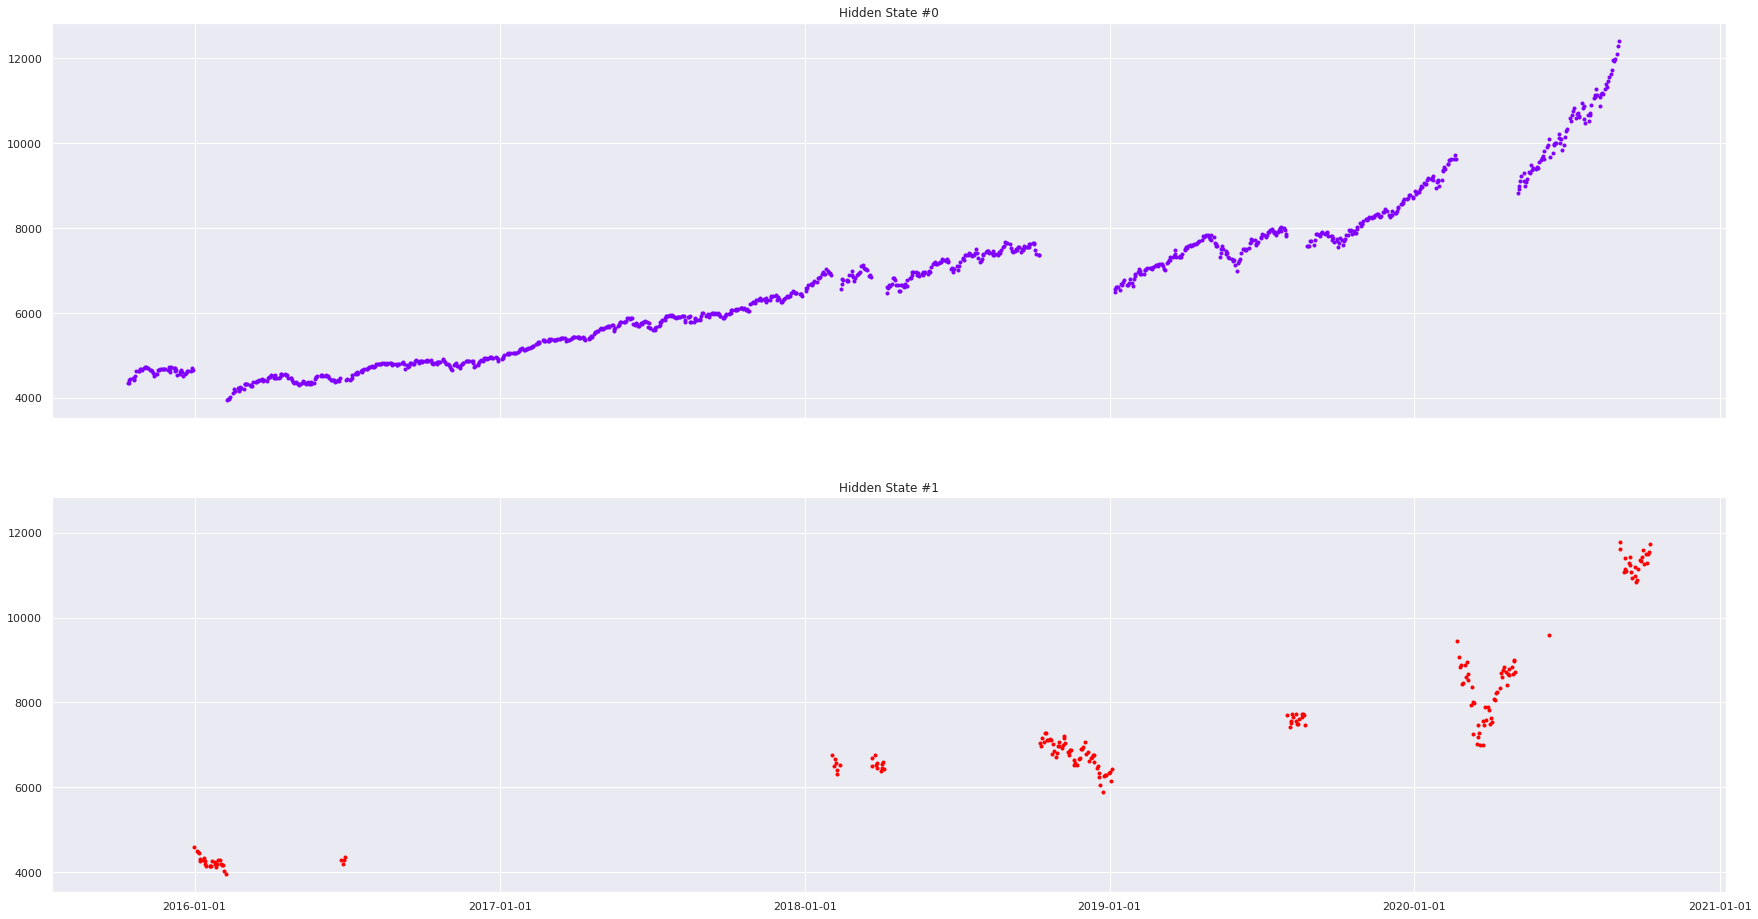

In [ ]:
# Hides deprecation warnings for sklearn
warnings.filterwarnings("ignore")

# Create dataframe from the Yahoo Finance CSV
# and correctly format the returns for use in the HMM
#csv_filepath = "data/1357.HK2.csv"
#pickle_path = "model/hmm_model_1357.pkl"
#csv_filepath = "model/data/1810.HK.csv"
#pickle_path = "model/hmm_model_1810.pkl"
#csv_filepath = "data/0005.HK.csv"
#pickle_path = "model/hmm_model_0005.pkl"
csv_filepath = "https://raw.githubusercontent.com/jackylshi/TrendStudyML/main/data/NDX.csv"
pickle_path = "model/hmm_model_NDX.pkl"
end_date = datetime.datetime(2020,10, 9)
res = obtain_prices_df(csv_filepath, end_date)
rets = np.column_stack([res["Returns"]])
#rets[numpy.isinf(rets)] = 0

# Create the Gaussian Hidden markov Model and fit it
# to the stock returns data, outputting a score
hmm_model = GaussianHMM(
    n_components=2, covariance_type="full", n_iter=10000
).fit(rets)
print("Model Score:", hmm_model.score(rets))

# Plot the in sample hidden states closing values
plot_in_sample_hidden_states(hmm_model, res)

# Step 2: Do the linear regression within each trend

In [ ]:
#add state into res dataframe
hidden_states = hmm_model.predict(rets)
res["state"]=hidden_states

#add trend into res dataframe
trend=0
hidden_trends=[]
for i in range(hidden_states.shape[0]):
    if i==0:
        trend+=1
    elif hidden_states[i]!=hidden_states[i-1]:
            trend+=1
    hidden_trends.append(trend)
res["trend"]=hidden_trends

#add new id for linear regression
res.insert(0, 'New_ID', range(1, 1 + len(res)))
res

,New_ID,Open,High,Low,Close,Adj Close,Volume,Returns,state,trend
Date,,,,,,,,,,
2015-10-13,1,4354.060059,4399.930176,4349.180176,4352.939941,4352.939941,1565060000,-0.006759,0,1
2015-10-14,2,4356.819824,4373.709961,4328.959961,4346.919922,4346.919922,1902460000,-0.001383,0,1
2015-10-15,3,4361.979980,4418.250000,4357.220215,4418.220215,4418.220215,1942900000,0.016402,0,1
2015-10-16,4,4419.950195,4438.750000,4405.879883,4438.620117,4438.620117,1855290000,0.004617,0,1
2015-10-19,5,4428.060059,4464.779785,4420.799805,4462.069824,4462.069824,1619920000,0.005283,0,1
...,...,...,...,...,...,...,...,...,...,...
2020-10-05,1254,11345.240234,11512.059570,11336.070313,11509.059570,11509.059570,3597940000,0.022510,1,18
2020-10-06,1255,11476.679688,11536.419922,11256.259766,11291.269531,11291.269531,4360550000,-0.018923,1,18
2020-10-07,1256,11412.650391,11519.549805,11382.480469,11503.190430,11503.190430,3891460000,0.018769,1,18


In [ ]:
grouped=res.groupby(['trend'])
# secular length can be defined here
df_filter=grouped.filter(lambda x: len(x) > 30)
dummy = pd.get_dummies(df_filter['trend']).values
x=df_filter.index
X = np.column_stack((df_filter['New_ID'], dummy))
y = np.array(df_filter['Adj Close'])

In [ ]:
res2 = sm.OLS(y, X).fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     4324.
Date:                Sun, 11 Oct 2020   Prob (F-statistic):               0.00
Time:                        08:02:48   Log-Likelihood:                -7857.8
No. Observations:                1114   AIC:                         1.574e+04
Df Residuals:                    1104   BIC:                         1.579e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             5.8136      0.114     50.992      0.0

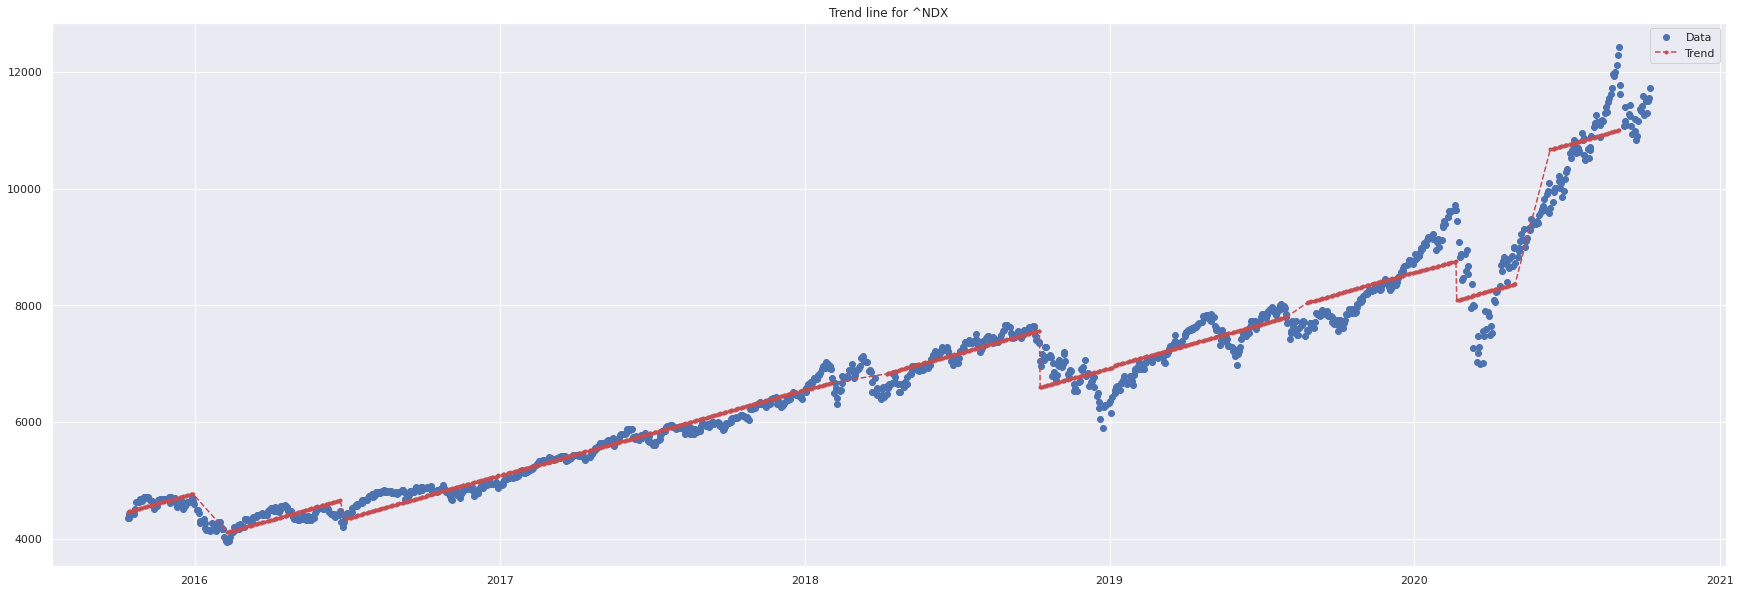

In [ ]:
prstd, iv_l, iv_u = wls_prediction_std(res2)

fig, ax = plt.subplots(figsize=(30,10))

plt.title('Trend line for ^NDX')

ax.plot(res.index, res['Adj Close'], 'o', label="Data")
ax.plot(x, res2.fittedvalues, 'r--.', label="Trend")
#ax.plot(x, iv_u, 'r--')
#ax.plot(x, iv_l, 'r--')
legend = ax.legend(loc="best")